In [28]:
from vivarium import Vivarium
from spatio_flux import PROCESS_DICT, TYPES_DICT

In [29]:
v = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)

In [30]:
v.get_types()

,Type
0,
1,integer
2,current*time/substance
3,length^0_5*mass^0_5
4,mass/time^2
...,...
97,length^0_5*mass^0_5/time
98,length^2*mass/current^2*time^2
99,schema
100,length^2*mass/current^2*time^3


In [31]:
# view the available processes
v.get_processes()

,Process
0,ram-emitter
1,MinimalParticle
2,composite
3,DynamicFBA
4,Particles
5,DiffusionAdvection
6,json-emitter
7,console-emitter


In [32]:
# inspect the config schema for the 'increase' process
v.process_schema('DynamicFBA')

'(model_file:string|kinetic_params:map[tuple[float,float]]|substrate_update_reactions:map[string]|biomass_identifier:string|bounds:map[bounds])'

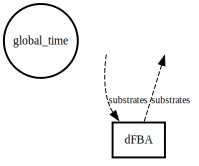

In [33]:
# add a dynamic FBA process called 'dFBA'
v.add_process(name="dFBA",
              process_id="DynamicFBA",
              config={
                "model_file": "textbook",
                "kinetic_params": {
                    "glucose": (0.5, 1),
                    "acetate": (0.5, 2)},
                "substrate_update_reactions": {
                    "glucose": "EX_glc__D_e",
                    "acetate": "EX_ac_e"},
                "biomass_identifier": "biomass",
                "bounds": {
                    "EX_o2_e": {"lower": -2, "upper": None},
                    "ATPM": {"lower": 1, "upper": 1}}},
              )
v.diagram(dpi='70')

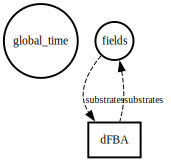

In [34]:
mol_ids = ["glucose", "acetate", "biomass"]
path=["fields"]
i = 0
j = 0

def build_path(mol_id):
    base_path = path + [mol_id]
    if i is not None:
        base_path.append(i)
    if j is not None:
        base_path.append(j)
    return base_path

# v.add_object(name="fields", type="array")
v.connect_process(
    process_name="dFBA",
    inputs={
            "substrates": ["fields",],  # {mol_id: ['fields', mol_id] for mol_id in mol_ids}
        },
    outputs={
            "substrates": ["fields",],  # {mol_id: ['fields', mol_id] for mol_id in mol_ids}
        }
    # inputs={
    #         "substrates": {mol_id: build_path(mol_id) for mol_id in mol_ids}
    #     },
    # outputs={
    #         "substrates": {mol_id: build_path(mol_id) for mol_id in mol_ids}
    #     }
)
v.diagram(dpi='70')

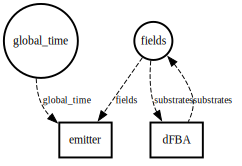

In [35]:
v.add_emitter()
v.diagram(dpi='70')

In [36]:
# run the simulation for 10 time units
v.run(interval=10)

KeyError: 'glucose'

In [ ]:
v.plot_timeseries()